# US Traffic Accidents Analysis
## Department of Transportation

# Step 0: Import Necessary Libraries
#### os - Provides a way to interact with operating system,File and directory operations, env varibles, process management
#### numpy - Used for scientific computing, especially working with arrays, math and data analysis
#### pandas - Used for Data analysis and manipulation, uses dataframes - a table like structure for analysis
#### matplotlib - Data visualization library allowing to create plots, charts and graphs

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#### Imports statistical library from Scipy
#### Imports statsmodels API usually needed for Time series models, regression models
#### Imports the formula-based interface under the name smf

In [3]:
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

##### This code imports tools from PySpark, which is the Python API for Apache Spark—a framework used for big data processing.
#### Note: Tried to use Pyspark but was having issues on my laptop for this big file, hence ended up doing this assignment mostly with pandas dataframe

In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, hour, dayofweek, month, year, when, isnan, count as spark_count
)

##### changes the visual style of your Matplotlib plots to look like the ggplot style

In [7]:
# For nicer plots
plt.style.use("ggplot")


# Step 1. BUSINESS UNDERSTANDING
"""
Goal (DOT perspective):
- Understand WHEN and WHERE accidents happen most frequently.
- Identify HOW weather and infrastructure relate to accident frequency and severity.
- Compare URBAN vs RURAL patterns.

Key questions:
1. Temporal patterns: At what times of day / week / year do accidents peak?
2. Spatial patterns: Which states / cities are hotspots?
3. Environmental factors: Do poor visibility, rain/snow, or low temperature increase accident severity?
4. Infrastructure: Which road features (junctions, traffic signals, etc.) relate to severity?
5. Urban vs rural: Are severity patterns different between urban and rural areas?

Success:
- At least 3 clear, data-driven insights with recommendations the DOT can use.
"""


# Step 2: Data Loading and Exploratory Analysis

In [9]:
# ---- Load data with Pandas (for EDA, stats, plots) ----
DATA_PATH = "US_Accidents_March23.csv" 

In [11]:
df = pd.read_csv(DATA_PATH)

In [13]:
# Quick peek
print("Shape:", df.shape)
print("\nColumns:\n", df.columns.tolist())
print("\nInfo:")
print(df.info())

Shape: (7728394, 46)

Columns:
 ['ID', 'Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7728394 entries, 0 to 7728393
Data columns (total 46 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   ID                     object 
 1   Source                 object 
 2   Severity               int64  
 3   Start_Time   

##### Prints Basic Descriptive Statistics for all Numeric Columns in a pandas DataFrame

In [15]:
print("\nBasic stats on numeric columns:")
print(df.describe().T)


Basic stats on numeric columns:
                       count       mean        std         min         25%  \
Severity           7728394.0   2.212384   0.487531    1.000000    2.000000   
Start_Lat          7728394.0  36.201195   5.076079   24.554800   33.399631   
Start_Lng          7728394.0 -94.702545  17.391756 -124.623833 -117.219396   
End_Lat            4325632.0  36.261829   5.272905   24.566013   33.462070   
End_Lng            4325632.0 -95.725570  18.107928 -124.545748 -117.754345   
Distance(mi)       7728394.0   0.561842   1.776811    0.000000    0.000000   
Temperature(F)     7564541.0  61.663286  19.013653  -89.000000   49.000000   
Wind_Chill(F)      5729375.0  58.251048  22.389832  -89.000000   43.000000   
Humidity(%)        7554250.0  64.831041  22.820968    1.000000   48.000000   
Pressure(in)       7587715.0  29.538986   1.006190    0.000000   29.370000   
Visibility(mi)     7551296.0   9.090376   2.688316    0.000000   10.000000   
Wind_Speed(mph)    7157161.0   

##### This code computes and displays the percentage of missing values for each column in a pandas DataFrame, sorted from most missing to least missing.

In [17]:
# Missing values overview
missing = df.isna().mean().sort_values(ascending=False)
print("\nMissing value ratio (top 20):")
print(missing.head(20))


Missing value ratio (top 20):
End_Lat                  0.440294
End_Lng                  0.440294
Precipitation(in)        0.285129
Wind_Chill(F)            0.258659
Wind_Speed(mph)          0.073914
Visibility(mi)           0.022915
Wind_Direction           0.022670
Humidity(%)              0.022533
Weather_Condition        0.022444
Temperature(F)           0.021201
Pressure(in)             0.018203
Weather_Timestamp        0.015557
Nautical_Twilight        0.003008
Civil_Twilight           0.003008
Sunrise_Sunset           0.003008
Astronomical_Twilight    0.003008
Airport_Code             0.002929
Street                   0.001406
Timezone                 0.001010
Zipcode                  0.000248
dtype: float64


##### This code converts date columns into proper datetime format and then creates new time-based features from them
##### errors="coerce" means:If a value cannot be parsed as a date → it becomes NaT (Not a Time).This ensures the columns can be used for date/time operations.
##### Other Temporal features like Year, Month, Hour, etc are extracted from the Start Time

In [19]:
# --- Parse dates & create temporal features ---
df["Start_Time"] = pd.to_datetime(df["Start_Time"], errors="coerce")
df["End_Time"] = pd.to_datetime(df["End_Time"], errors="coerce")

df["Year"] = df["Start_Time"].dt.year
df["Month"] = df["Start_Time"].dt.month
df["Hour"] = df["Start_Time"].dt.hour
df["DayOfWeek"] = df["Start_Time"].dt.dayofweek  # Monday=0
df["Is_Weekend"] = df["DayOfWeek"].isin([5, 6]).astype(int)

##### This code creates a new categorical column called "Daypart" based on the hour of the day. It uses a custom function to classify each hour into Morning, Midday, Evening, or Night.
##### Defines a Function to Categorize the Hour

In [21]:
# Time-of-day bins
def categorize_daypart(h):
    if pd.isna(h):
        return np.nan
    if 5 <= h < 10:
        return "Morning"
    elif 10 <= h < 16:
        return "Midday"
    elif 16 <= h < 20:
        return "Evening"
    else:
        return "Night"

df["Daypart"] = df["Hour"].apply(categorize_daypart)

##### This code simplifies detailed weather descriptions into broader, easier-to-analyze categories. It creates a new column called Weather_Simple based on the original "Weather_Condition" text.

In [23]:
# --- Simplify weather ----
def simplify_weather(cond):
    if pd.isna(cond):
        return "Unknown"
    cond = cond.lower()
    if "snow" in cond or "sleet" in cond or "ice" in cond:
        return "Snow/Ice"
    if "rain" in cond or "storm" in cond or "drizzle" in cond or "thunder" in cond:
        return "Rain/Storm"
    if "fog" in cond or "mist" in cond or "haze" in cond or "smoke" in cond:
        return "Low Visibility"
    if "cloud" in cond or "overcast" in cond:
        return "Cloudy"
    if "clear" in cond or "fair" in cond:
        return "Clear"
    return "Other"

df["Weather_Simple"] = df["Weather_Condition"].apply(simplify_weather)

##### This code creates a new column called Urban_Rural that classifies each row as “Urban” or “Rural” based on two conditions.
##### Condition 1- This returns True if BOTH are true, Con d 2= There is a traffic signal present at the locaton

In [25]:
# --- Urban vs Rural proxy ---
# Simple heuristic: city with population > threshold if we had external data.
# Since we don't, we'll approximate: accidents inside a City with a Traffic_Signal as "Urban",
# and those without as "Rural" (crude but illustrative).
df["Urban_Rural"] = np.where(
    (df["City"].notna()) & (df["Traffic_Signal"] == True),
    "Urban",
    "Rural"
)

##### This code performs basic data cleaning by filling missing numeric values, dropping rows missing critical fields, and then reporting the final dataset shape

In [27]:
# --- Handle missing values in key numeric fields ---
numeric_cols = [
    "Temperature(F)", "Humidity(%)", "Pressure(in)",
    "Visibility(mi)", "Wind_Speed(mph)", "Precipitation(in)", "Distance(mi)"
]

for col_name in numeric_cols:
    if col_name in df.columns:
        median_val = df[col_name].median()
        df[col_name] = df[col_name].fillna(median_val)

# Drop rows missing critical fields (e.g., Severity, Start_Lat, Start_Lng)
critical_cols = ["Severity", "Start_Lat", "Start_Lng", "Start_Time"]
df = df.dropna(subset=critical_cols)

print("\nShape after basic cleaning:", df.shape)


Shape after basic cleaning: (6985228, 54)


# Step 3: Analysis, Statistical Analysis/Data Visualization

##### 3.1 Temporal & Spatial Patterns

##### Bar chart showing how many accidents occur during each hour of the day.

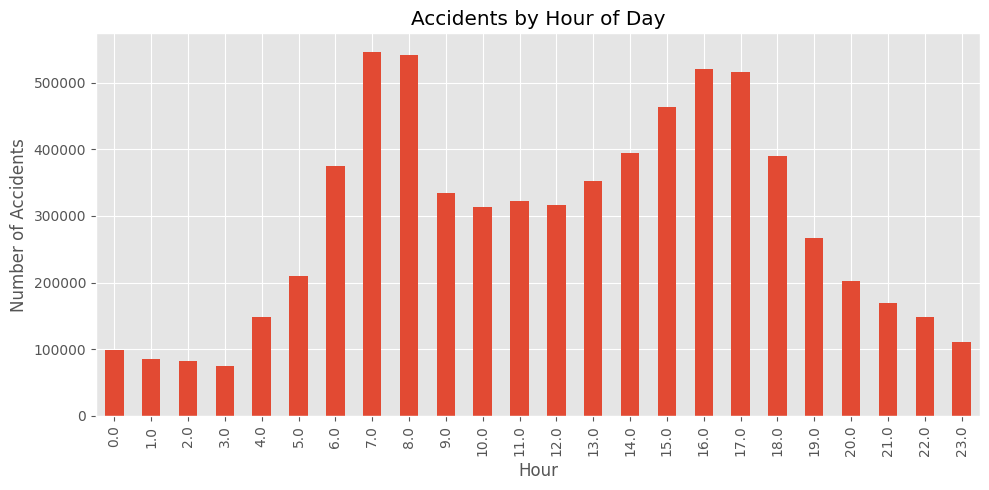

In [29]:
# ---- Accidents by hour ----
hour_counts = df["Hour"].value_counts().sort_index()

plt.figure(figsize=(10, 5))
hour_counts.plot(kind="bar")
plt.title("Accidents by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Number of Accidents")
plt.tight_layout()
plt.show()

###### Bar chart showing how many accidents occur on each day of the week

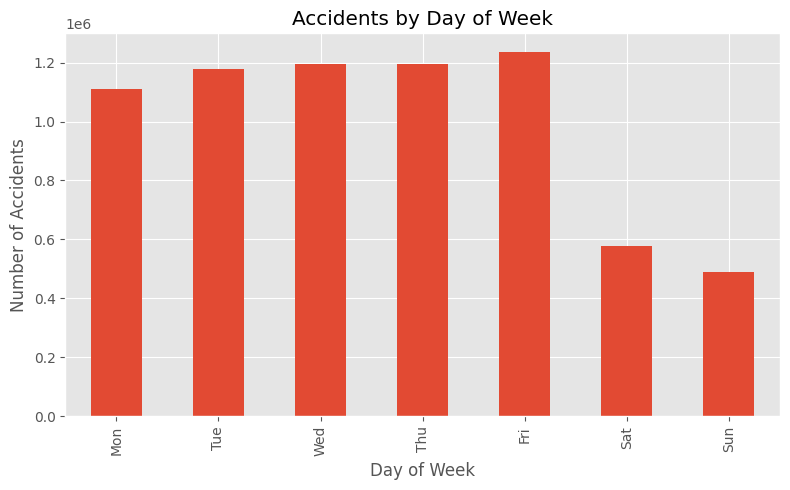

In [31]:
# ---- Accidents by day of week ----
dow_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
dow_counts = df["DayOfWeek"].value_counts().sort_index()

plt.figure(figsize=(8, 5))
dow_counts.index = dow_labels
dow_counts.plot(kind="bar")
plt.title("Accidents by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Number of Accidents")
plt.tight_layout()
plt.show()

##### Bar chart of the top 10 U.S. states with the highest number of accidents in the dataset

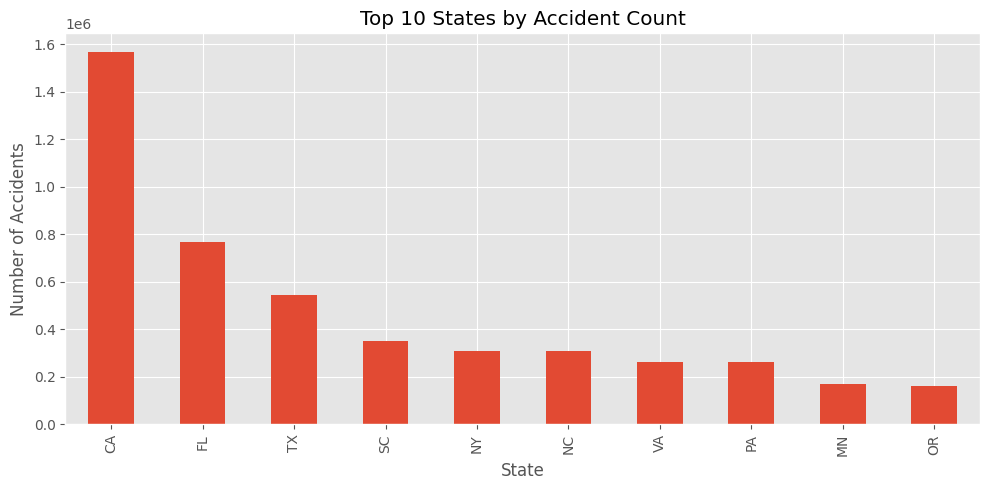

In [33]:
# ---- Accidents by state (top 10) ----
state_counts = df["State"].value_counts().head(10)
plt.figure(figsize=(10, 5))
state_counts.plot(kind="bar")
plt.title("Top 10 States by Accident Count")
plt.xlabel("State")
plt.ylabel("Number of Accidents")
plt.tight_layout()
plt.show()

#### 3.2 Environmental Factors and Severity

##### Bar chart showing how accidents are distributed across different severity levels

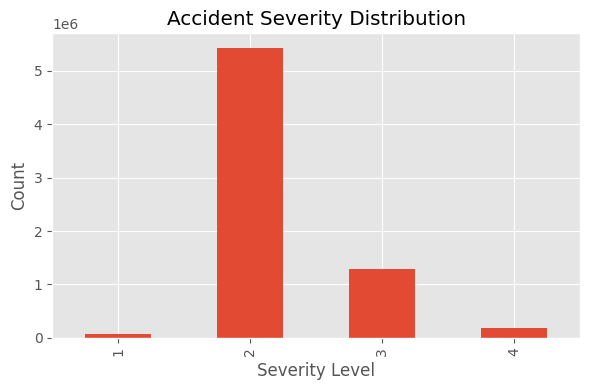

In [35]:
# Severity distribution
severity_counts = df["Severity"].value_counts().sort_index()
plt.figure(figsize=(6, 4))
severity_counts.plot(kind="bar")
plt.title("Accident Severity Distribution")
plt.xlabel("Severity Level")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

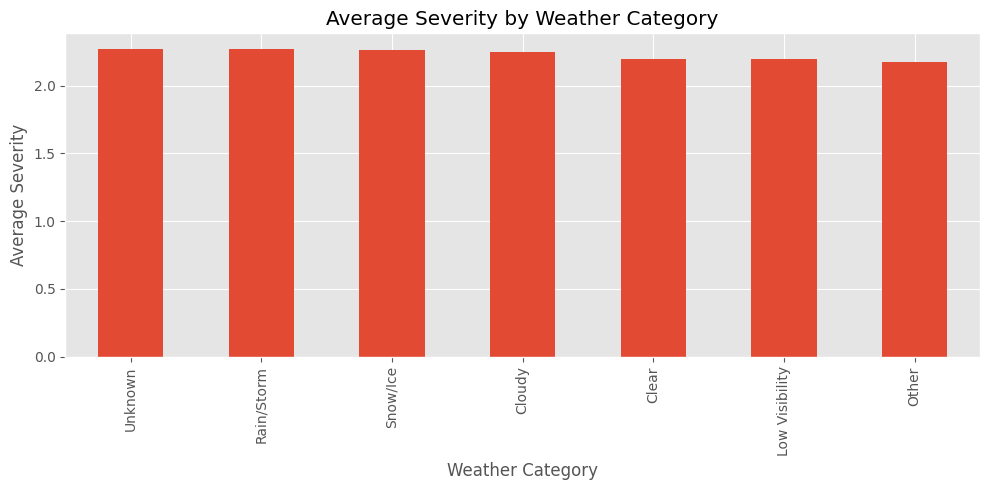

In [37]:
# Compare severity under different simplified weather conditions
weather_sev = (
    df.groupby("Weather_Simple")["Severity"]
      .mean()
      .sort_values(ascending=False)
)

plt.figure(figsize=(10, 5))
weather_sev.plot(kind="bar")
plt.title("Average Severity by Weather Category")
plt.xlabel("Weather Category")
plt.ylabel("Average Severity")
plt.tight_layout()
plt.show()

In [39]:
print("\nAverage severity by simplified weather condition:")
print(weather_sev)


Average severity by simplified weather condition:
Weather_Simple
Unknown           2.272208
Rain/Storm        2.267945
Snow/Ice          2.265609
Cloudy            2.251186
Clear             2.199997
Low Visibility    2.192991
Other             2.173786
Name: Severity, dtype: float64


##### Code performs a statistical hypothesis test (a two-sample t-test) to determine whether accident severity differs between Clear weather and Rain/Storm weather
##### t-statistic → how far apart the group means are (in standard units)
##### p-value → probability that the difference happened by random chance
##### A small p-value (< 0.05) → statistically significant difference

In [41]:
# Statistical test: Does severity differ between Clear vs Rain/Storm?
subset = df[df["Weather_Simple"].isin(["Clear", "Rain/Storm"])].copy()
group_clear = subset[subset["Weather_Simple"] == "Clear"]["Severity"]
group_rain = subset[subset["Weather_Simple"] == "Rain/Storm"]["Severity"]

t_stat, p_val = stats.ttest_ind(group_clear, group_rain, equal_var=False)
print("\nT-test: Severity Clear vs Rain/Storm")
print(f"t-statistic = {t_stat:.3f}, p-value = {p_val:.6f}")


T-test: Severity Clear vs Rain/Storm
t-statistic = -90.956, p-value = 0.000000


#### 3.3 Infrastructure & Severity

##### Code calculates how accident severity changes depending on whether certain infrastructure features are present (like traffic signals, junctions, crossings, or stop signs)

In [43]:
# Example infrastructure features: Junction, Traffic_Signal, Crossing, Stop
infra_cols = ["Junction", "Traffic_Signal", "Crossing", "Stop"]
infra_impact = {}

for col_name in infra_cols:
    if col_name in df.columns:
        avg_sev_present = df[df[col_name] == True]["Severity"].mean()
        avg_sev_absent = df[df[col_name] != True]["Severity"].mean()
        infra_impact[col_name] = {
            "avg_severity_present": avg_sev_present,
            "avg_severity_absent": avg_sev_absent
        }

print("\nInfrastructure impact on severity (mean severity):")
for k, v in infra_impact.items():
    print(
        f"{k}: present={v['avg_severity_present']:.3f}, "
        f"absent={v['avg_severity_absent']:.3f}"
    )



Infrastructure impact on severity (mean severity):
Junction: present=2.322, absent=2.222
Traffic_Signal: present=2.091, absent=2.255
Crossing: present=2.067, absent=2.250
Stop: present=2.078, absent=2.234


In [ ]:
##### Code performs a Chi-square test of independence to check whether accident severity is statistically related to the time of day (Daypart).

In [45]:
# Chi-square test: Severity vs Daypart
cont_table = pd.crosstab(df["Severity"], df["Daypart"])
chi2, p, dof, expected = stats.chi2_contingency(cont_table)

print("\nChi-square test: Severity vs Daypart")
print("Chi2:", chi2, "p-value:", p)


Chi-square test: Severity vs Daypart
Chi2: 36227.639143167005 p-value: 0.0


##### This shows how many accidents of each severity occur in each daypart

In [87]:
cont_table

Daypart,Evening,Midday,Morning,Night
Severity,,,,
1,16585,14746,29359,6674
2,1299090,1692857,1558954,882977
3,340255,402411,377976,178615
4,38539,53177,40968,52045


#### 3.4 Urban V Rural Comparsion

##### This code analyzes how accidents differ between urban and rural areas by
##### Counting how many accidents occur in each
##### Calculating the average severity for urban vs rural accidents

In [90]:
urban_rural_counts = df["Urban_Rural"].value_counts()
print("\nUrban vs Rural accident counts:")
print(urban_rural_counts)

# Average severity by Urban/Rural
ur_severity = df.groupby("Urban_Rural")["Severity"].mean()
print("\nAverage severity by Urban_Rural:")
print(ur_severity)


Urban vs Rural accident counts:
Urban_Rural
Rural    5897067
Urban    1088161
Name: count, dtype: int64

Average severity by Urban_Rural:
Urban_Rural
Rural    2.254748
Urban    2.091055
Name: Severity, dtype: float64


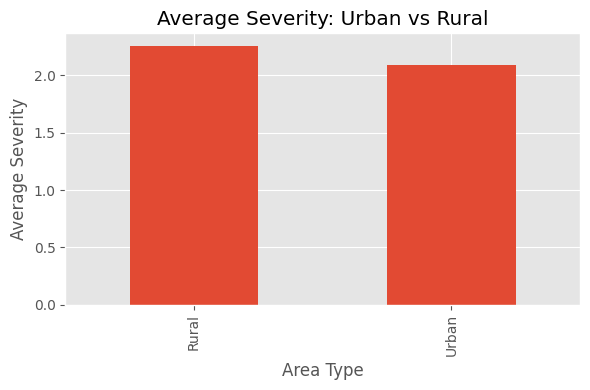

In [49]:
plt.figure(figsize=(6, 4))
ur_severity.plot(kind="bar")
plt.title("Average Severity: Urban vs Rural")
plt.xlabel("Area Type")
plt.ylabel("Average Severity")
plt.tight_layout()
plt.show()

In [51]:
# Chi-square: Severity vs Urban_Rural
cont_ur = pd.crosstab(df["Severity"], df["Urban_Rural"])
chi2_ur, p_ur, dof_ur, expected_ur = stats.chi2_contingency(cont_ur)

print("\nChi-square test: Severity vs Urban_Rural")
print("Chi2:", chi2_ur, "p-value:", p_ur)


Chi-square test: Severity vs Urban_Rural
Chi2: 124968.40860052034 p-value: 0.0


##### This code fits a logistic regression model to predict whether an accident is high severity (3–4) vs low severity (1–2) based on several factors (distance, weather, time of day, etc.), and then prints the full model summary.

In [95]:
# 3.5 Multivariate Model (Statsmodels)
# Logistic regression: High Severity (3-4) vs Low (1-2)


df["High_Severity"] = (df["Severity"] >= 3).astype(int)

# Select a smaller sample for speed if dataset is huge
sample = df.sample(n=200_000, random_state=42) if len(df) > 200_000 else df.copy()

# Features: Distance, Weather, Daypart, Urban/Rural, Is_Weekend
# Build formula
formula = "High_Severity ~ Q('Distance(mi)') + C(Weather_Simple) + C(Daypart) + C(Urban_Rural) + Is_Weekend"

logit_model = smf.logit(formula=formula, data=sample).fit(disp=False)
print("\nLogistic Regression: High Severity vs factors")
print(logit_model.summary())



Logistic Regression: High Severity vs factors
                           Logit Regression Results                           
Dep. Variable:          High_Severity   No. Observations:               200000
Model:                          Logit   Df Residuals:                   199987
Method:                           MLE   Df Model:                           12
Date:                Wed, 03 Dec 2025   Pseudo R-squ.:                 0.02188
Time:                        22:57:50   Log-Likelihood:            -1.0124e+05
converged:                       True   LL-Null:                   -1.0350e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              -1.3362      0.013   -100.582      0.000      -1.362      -1.310
C(Weather

In [ ]:
# Step 4: Evaluation and 

In [57]:
# 5. EVALUATION & INSIGHTS
# ------------------------------

# Here we derive 3 clear, data-driven insights for DOT.
# You can refine thresholds and wording based on actual numbers.

# Example Insight 1: Peak times
peak_hour = hour_counts.idxmax()
peak_hour_count = hour_counts.max()

# Example Insight 2: Weather severity difference
mean_clear = group_clear.mean()
mean_rain = group_rain.mean()

# Example Insight 3: Urban vs Rural severity
mean_urban = ur_severity.get("Urban", np.nan)
mean_rural = ur_severity.get("Rural", np.nan)

print("\n================ DOT INSIGHTS (DRAFT) ================\n")

print(f"1) Temporal Hotspot:")
print(
    f"   • The peak accident hour is around {peak_hour}:00 "
    f"with ~{peak_hour_count} accidents in the dataset. "
    "Evening rush hours and late-night periods may require targeted enforcement and campaigns."
)

print("\n2) Weather and Severity:")
print(
    f"   • Average severity on Clear conditions: {mean_clear:.2f}\n"
    f"   • Average severity during Rain/Storm:  {mean_rain:.2f}\n"
    f"   • T-test p-value = {p_val:.6f}. If p < 0.05, this suggests significantly higher severity "
    "in rain/storm, supporting investment in wet-weather driving campaigns, drainage, and roadway friction improvements."
)

print("\n3) Urban vs Rural Severity:")
print(
    f"   • Average severity in Urban-like areas: {mean_urban:.2f}\n"
    f"   • Average severity in Rural-like areas: {mean_rural:.2f}\n"
    f"   • Chi-square p-value (Severity x Urban_Rural) = {p_ur:.6f}. "
    "If severity is higher in rural areas, DOT might prioritize EMS response time improvements, "
    "lighting, and geometric design improvements on rural roadways."
)

print("\n======================================================")



================ DOT INSIGHTS (DRAFT) ================

1) Temporal Hotspot:
   • The peak accident hour is around 7.0:00 with ~546789 accidents in the dataset. Evening rush hours and late-night periods may require targeted enforcement and campaigns.

2) Weather and Severity:
   • Average severity on Clear conditions: 2.20
   • Average severity during Rain/Storm:  2.27
   • T-test p-value = 0.000000. If p < 0.05, this suggests significantly higher severity in rain/storm, supporting investment in wet-weather driving campaigns, drainage, and roadway friction improvements.

3) Urban vs Rural Severity:
   • Average severity in Urban-like areas: 2.09
   • Average severity in Rural-like areas: 2.25
   • Chi-square p-value (Severity x Urban_Rural) = 0.000000. If severity is higher in rural areas, DOT might prioritize EMS response time improvements, lighting, and geometric design improvements on rural roadways.

